In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

raw_train_set = ImageFolder("img/", transform=transform)
BATCH_SIZE = 128

In [4]:
raw_train_set.class_to_idx

{'00000': 0,
 '00001': 1,
 '00002': 2,
 '00003': 3,
 '00004': 4,
 '00005': 5,
 '00006': 6,
 '00007': 7,
 '00008': 8,
 '00009': 9,
 '00010': 10,
 '00011': 11,
 '00012': 12,
 '00013': 13,
 '00014': 14,
 '00015': 15,
 '00016': 16,
 '00017': 17,
 '00018': 18,
 '00019': 19,
 '00020': 20,
 '00021': 21,
 '00022': 22,
 '00023': 23,
 '00024': 24,
 '00025': 25,
 '00026': 26,
 '00027': 27,
 '00028': 28,
 '00029': 29,
 '00030': 30,
 '00031': 31,
 '00032': 32,
 '00033': 33,
 '00034': 34,
 '00035': 35,
 '00036': 36,
 '00037': 37,
 '00038': 38,
 '00039': 39,
 '00040': 40,
 '00041': 41,
 '00042': 42}

In [5]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)


train_data, test_data = split_dataset(raw_train_set, 0.2, 42)
#### Dataloadery
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

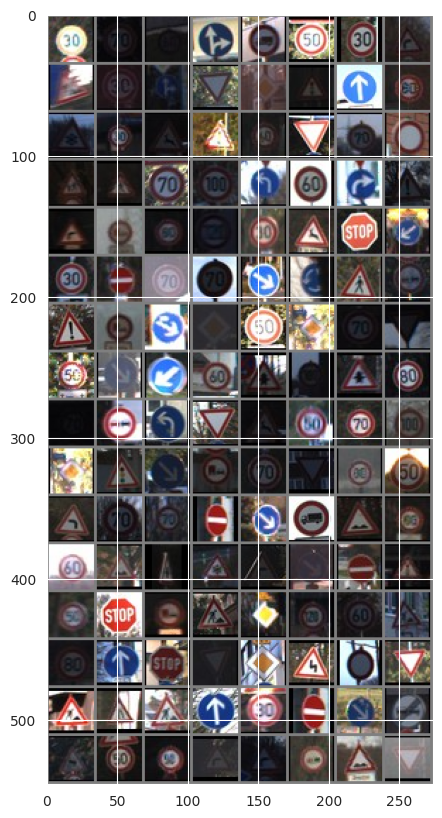

00001 00004 00003 00036 00016 00002 00001 00020 00025 00001 00036 00013 00012 00026 00035 00005 00030 00001 00031 00026 00003 00013 00004 00015 00028 00027 00004 00007 00034 00003 00033 00018 00020 00010 00005 00008 00001 00031 00014 00039 00001 00017 00004 00004 00038 00040 00027 00009 00018 00010 00038 00012 00002 00012 00004 00013 00002 00038 00039 00003 00011 00007 00011 00005 00004 00009 00034 00013 00031 00002 00004 00007 00012 00026 00038 00010 00004 00013 00005 00002 00019 00004 00004 00017 00038 00016 00022 00005 00003 00022 00011 00030 00020 00038 00017 00026 00002 00014 00010 00025 00012 00008 00003 00025 00005 00035 00014 00013 00012 00021 00015 00013 00025 00024 00025 00035 00001 00017 00038 00041 00023 00002 00002 00020 00020 00009 00022 00013


In [6]:
plt.figure(figsize=(20, 10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [7]:
images[0:1].size()

torch.Size([1, 3, 32, 32])

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat


class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

    def reparameterization(self, mean, var):
        # Change to proper
        epsilon = torch.randn(mean.shape).to(device)
        z = mean + epsilon * var
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [16]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=32*32*3).to(device)


def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD


optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 174651.1230230564, test L1 = 0.5763453677777322
Epoch 1 loss 162173.77381065802, test L1 = 0.5692550040060474
Epoch 2 loss 159497.5924320376, test L1 = 0.5639450357806298
Epoch 3 loss 157321.49570074314, test L1 = 0.5603347074600958
Epoch 4 loss 156208.8820582444, test L1 = 0.5556337487313056
Epoch 5 loss 155489.64259400408, test L1 = 0.5550152822848289
Epoch 6 loss 154867.08858930386, test L1 = 0.5518115153235774
Epoch 7 loss 154323.768376048, test L1 = 0.551784792254048
Epoch 8 loss 153894.85946233486, test L1 = 0.5493183039849804
Epoch 9 loss 153555.7349506161, test L1 = 0.5485630150764219
Epoch 10 loss 153282.28927289761, test L1 = 0.5478030510487095
Epoch 11 loss 153025.91470361725, test L1 = 0.5470205122424711
Epoch 12 loss 152823.4606675559, test L1 = 0.5467660023320106
Epoch 13 loss 152665.8075139736, test L1 = 0.5456739029576702
Epoch 14 loss 152508.62675860646, test L1 = 0.5457632753156847
Epoch 15 loss 152400.64908060213, test L1 = 0.5446046504282183
Epoch 16 lo